In [1]:
# Instalando dependências
# !pip install -q -U "tensorflow-text==2.8.*"

# !pip install -q tf-models-official

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # Cria AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [3]:
# Download IMDB dataset

url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [4]:
#Valores padrões
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 10

# Cria dataset de treino
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2, # 20% dos dados de treinos separados para validação
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Cria dataset de teste
test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [5]:
# Imprime 3 comentários
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'There are laughs in this film, that is for sure. Michael Keaton is a talent and he used to be funny (before he decided he was a serious actor). However, what bothers me so much about this film, is how unlikable practically all of the characters are. Other than the main two leads, everybody is a jerk. I mean, these small town losers are about as uncouth as you can get. You just watch and think, man, these losers should be unemployed. Moreover, the American factory worker is portrayed as a lazy and ungrateful slob. It made me wonder if this film was made by Japanese nationalists. Oh sure, in the end they all come together as one, but I just did not enjoy the trip to get there.'
Label : 0 (neg)
Review: b'Stephen J. Cannell apparently decided a few years ago that he would broaden his horizons and dabble in horror. The result, "Dead Above Ground", is an abysmal piece of junk. Now, had I noticed his name in association with THIS particular film I\'d have put it back but no, I didn\

In [6]:
# Selecionando o modelo BERT (BERT Multilingual)

#Nome do modelo
# bert_model_name = 'bert_multi_cased_L-12_H-768_A-12' 

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

#Endereço do modelo TensorHub
map_name_to_handle = {
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
}

#Pré-processador para o modelo escolhido
map_model_to_preprocess = {
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]

tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT modelo selecionado           : {tfhub_handle_encoder}')
print(f'Pré-processador do modelo selecionado: {tfhub_handle_preprocess}')

BERT modelo selecionado           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pré-processador do modelo selecionado: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [7]:
# Carrega o modelo de pré-processamento
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [8]:
# Validando modelo

text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Ids das palavras  : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Ids das palavras  : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [9]:
# Função para criar o modelo BERT

def build_classifier_model():
    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    
    encoder_inputs = preprocessing_layer(text_input)
    
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    
    outputs = encoder(encoder_inputs)
    
    net = outputs['pooled_output']
    
    net = tf.keras.layers.Dropout(0.1)(net)
    
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

In [10]:
#Validando o funcionamento do modelo com a saída do pré-processamento
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.9140357]], shape=(1, 1), dtype=float32)


In [11]:
# Cria a função de perda para um modelo de classificação binária

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [12]:
# Define optimizador para o treinamento do modelo

#Número de épocas
epochs = 5

steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

#Taxa de inicialização
init_lr = 3e-5

#Otimizador
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [13]:
# Compila o modelo
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [14]:
# Treinamento do modelo

print(f'Treinando o modelo com: {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Treinando o modelo com: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 276s 435ms/step - loss: 0.5107 - binary_accuracy: 0.7322 - val_loss: 0.3796 - val_binary_accuracy: 0.8244
Epoch 2/5
625/625 [==============================] - 269s 431ms/step - loss: 0.3297 - binary_accuracy: 0.8513 - val_loss: 0.3882 - val_binary_accuracy: 0.8358
Epoch 3/5
625/625 [==============================] - 270s 432ms/step - loss: 0.2512 - binary_accuracy: 0.8971 - val_loss: 0.4116 - val_binary_accuracy: 0.8456
Epoch 4/5
625/625 [==============================] - 269s 431ms/step - loss: 0.1926 - binary_accuracy: 0.9265 - val_loss: 0.4457 - val_binary_accuracy: 0.8528
Epoch 5/5
625/625 [==============================] - 269s 430ms/step - loss: 0.1520 - binary_accuracy: 0.9428 - val_loss: 0.4737 - val_binary_accuracy: 0.8542


In [15]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 142s 182ms/step - loss: 0.4655 - binary_accuracy: 0.8532
Loss: 0.4654960632324219
Accuracy: 0.8532400131225586


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


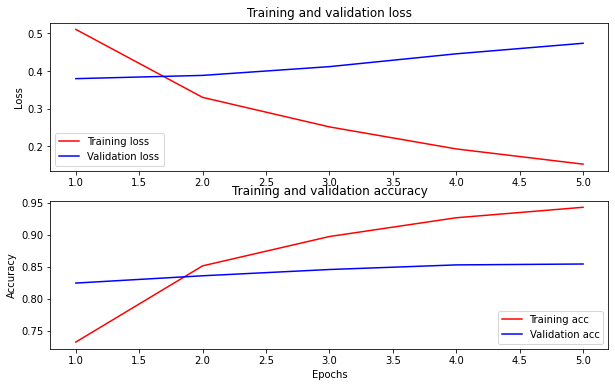

In [16]:
#Plotando métricas de avaliação
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')